In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

from utils.new_or_used import build_dataset
from utils.funcs import transform_x, show_evaluation

warnings.filterwarnings('ignore')
%matplotlib inline

### 1. Leer los datos

Se utilizó la función predefinada en el ejercicio: `build_dataset` para dividir los datos en entrenamiento y prueba.

In [2]:
X_train_org, y_train_org, X_test_org, y_test_org = build_dataset()

### 2. Transformar los datos

> *Nota:* Todas las transformaciones se empaquetaron en la función `transform_x` dentro del archivo `utils.func.py`.

1. Se reorganizó la estructura de los datos originales, los cuales tenían una estructura de json anidados. 
2. Se eliminaron las variables que no eran relevantes para el problema.
3. Se crearon nuevas variables como algunas categoricas a partir de continuas como el numero de productos en stocl o vendidos. 

In [5]:
# La variable objetivo toma el valor de 1 si es nuevo y 0 si es usado
y_train = [1 if x == 'new' else 0 for x in y_train_org]
y_test = [1 if x == 'new' else 0 for x in y_test_org]

# Crear dataframe X_train and X_test
X_train_df = pd.DataFrame(X_train_org)
X_test_df = pd.DataFrame(X_test_org)

# Limpiar y transformar dataframes
X_train_df = transform_x(X_train_df)
X_test_df = transform_x(X_test_df)

# Se incluye la variable objetivo en X_train para data analysis
X_train_df["target"] = y_train

X_train_df.head(5)


,warranty,sub_status,condition,seller_id,listing_type_id,price,buying_mode,category_id,last_updated,pictures,...,number_variations,has_attributes,number_attributes,has_warranty,sold_quantity_category,available_quantity_category,time_diff,days_active,days_active_category,target
0,None,none,new,8208882349,bronze,80.0,buy_it_now,MLA126406,2015-09-05T20:42:58.000Z,"[{'size': '500x375', 'secure_url': 'https://a2...",...,0,0,0,0,0,0,5.18400,0,0. 0,1
1,NUESTRA REPUTACION,none,used,8141699488,silver,2650.0,buy_it_now,MLA10267,2015-09-26T18:08:34.000Z,"[{'size': '499x334', 'secure_url': 'https://a2...",...,0,0,0,1,0,0,5.18400,0,0. 0,0
2,None,none,used,8386096505,bronze,60.0,buy_it_now,MLA1227,2015-09-09T23:57:10.000Z,"[{'size': '375x500', 'secure_url': 'https://a2...",...,0,0,0,0,0,0,5.18400,0,0. 0,0
3,None,none,new,5377752182,silver,580.0,buy_it_now,MLA86345,2015-10-05T16:03:50.306Z,"[{'size': '441x423', 'secure_url': 'https://a2...",...,0,0,0,0,0,0,5.72552,6,1. 1-7,1
4,MI REPUTACION.,none,used,2938071313,bronze,30.0,buy_it_now,MLA41287,2015-08-28T13:37:41.000Z,"[{'size': '375x500', 'secure_url': 'https://a2...",...,0,0,0,1,0,0,5.18400,3,1. 1-7,0


In [6]:
X_train_df.columns

Index(['warranty', 'sub_status', 'condition', 'seller_id', 'listing_type_id',
       'price', 'buying_mode', 'category_id', 'last_updated', 'pictures', 'id',
       'accepts_mercadopago', 'currency_id', 'title', 'automatic_relist',
       'date_created', 'stop_time', 'status', 'initial_quantity', 'start_time',
       'sold_quantity', 'available_quantity', 'seller_country', 'seller_state',
       'seller_city', 'shipping_local_pick_up', 'shipping_tags',
       'shipping_free_shipping', 'shipping_mode', 'nmp_payment_visa',
       'nmp_payment_giro_postal', 'nmp_payment_efectivo',
       'nmp_payment_contra_reembolso', 'nmp_payment_cheque_certificado',
       'nmp_payment_transferencia_bancaria', 'nmp_payment_mastercard',
       'nmp_payment_acordar_con_el_comprador', 'nmp_payment_visa_electron',
       'nmp_payment_mercadopago', 'nmp_payment_american_express',
       'nmp_payment_diners', 'nmp_payment_tarjeta_de_crédito',
       'nmp_payment_mastercard_maestro', 'tag_poor_quality_thumbna

### 3. Modelos

#### 3.1. Modelo base logit
Modelo simple de baseline sin optimización de hiperparametros, ni seleccion de features.

> Solo con estas carateristicas da el minimo esperado de accuracy: `0.8611` y un ROC AUC de `0.9338`

Los siguientes pasos serán entonces mejorar el modelo baseline y probar otros modelos.

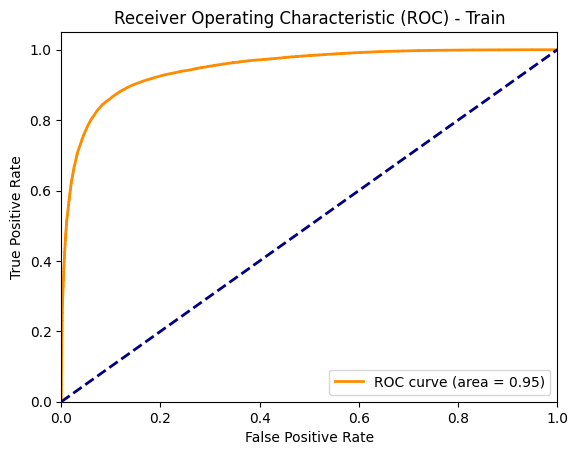

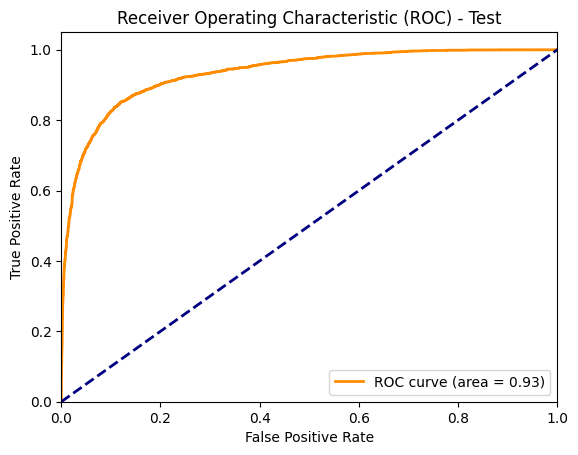

Evaluation using accuracy:
Accuracy train: 0.8799
Accuracy validation: 0.8605
Accuracy test: 0.8611

Evaluation using ROC AUC:
ROC AUC train: 0.9478
ROC AUC validation: 0.9340
ROC AUC test: 0.9338

Reporte de clasificacion del conjunto test:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      4594
           1       0.87      0.88      0.87      5406

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('txt',
                                                  TfidfVectorizer(max_features=10000),
                                                  'title'),
                                                 ('cat', OneHotEncoder(),
                                                  ['sold_quantity_category',
                                                   'listing_type_id']),
                                                 ('num', StandardScaler(),
                                                  ['price', 'days_active'])])),
                ('classifier', LogisticRegression())])

In [9]:
# Lista de variables de interes de acuerdo al EDA
features_list = ['title', 'price', 'sold_quantity_category', 'listing_type_id', 'days_active']

# Seleccionar variables de interés
X_train = X_train_df[features_list]
X_test = X_test_df[features_list]

modelo = LogisticRegression()

# Preprocesamiento de datos
# TfidfVectorizer para textos
# OneHotEncoder para las categoricas
# StandardScaler para las variables continuas
preprocessor = ColumnTransformer(
    transformers=[
        ('txt', TfidfVectorizer(max_features=10000), 'title'),
        ('cat', OneHotEncoder(), ['sold_quantity_category', 'listing_type_id']),
        ('num', StandardScaler(), ['price', 'days_active'])
    ])

# Crear el pipeline con el preprocesador y el modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])


pipeline = show_evaluation(X_train, y_train, X_test, y_test, pipeline, show_test=True)

pipeline

#### 3.2. Modelo base logit mejorado

1. Se fueron incluyendo las variables una a una dependiendo de la intuición del EDA para ver como mejoraban la clasificacion. Hasta obtener el mejor set de variables.
2. Se hizo optimización de hiperparamtros para mejorar la estimacón anterior entoncontrada en el punto 1.
3. Despues de todo esto se alcanzó un **Accuracy** de `0.8879` y un **ROC AUC** de `0.9524`. Mejorando asi el clasificador base.

Best parameters found:  {'classifier__C': 1}
Best cross-validation score (ROC AUC):  0.9517744239097379



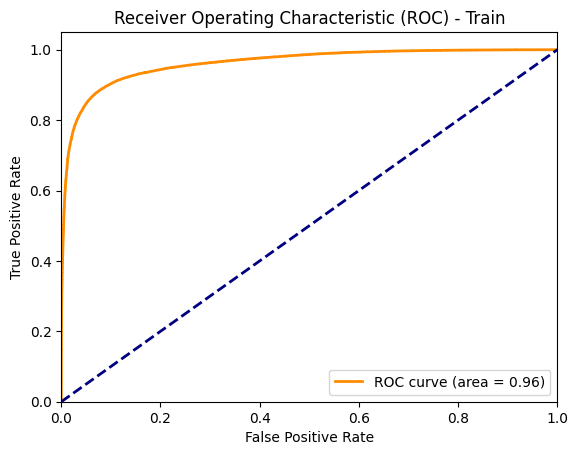

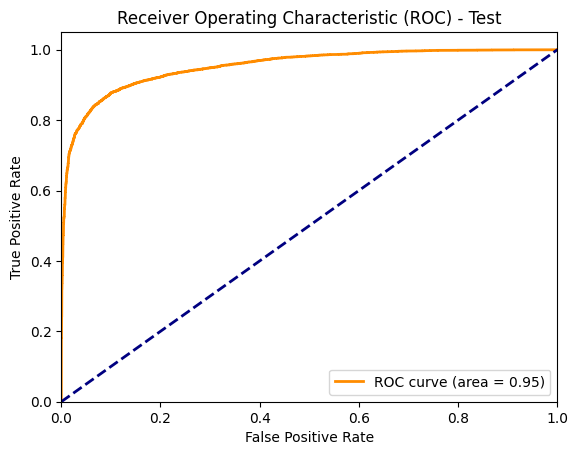

Evaluation using accuracy:
Accuracy train: 0.9022
Accuracy validation: 0.8879
Accuracy test: 0.8879

Evaluation using ROC AUC:
ROC AUC train: 0.9616
ROC AUC validation: 0.9518
ROC AUC test: 0.9524

Reporte de clasificacion del conjunto test:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4594
           1       0.91      0.88      0.89      5406

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('titulo',
                                                  TfidfVectorizer(max_features=10000),
                                                  'title'),
                                                 ('garantia',
                                                  TfidfVectorizer(max_features=10000),
                                                  'warranty'),
                                                 ('cat', OneHotEncoder(),
                                                  ['sold_quantity_category',
                                                   'listing_type_id',
                                                   'buying_mode',
                                                   'shipping_mode',
                                                   'available_quantity_category',
                                                   'shipping_local_pick_up',
                                                   'shipping_free_shipping',
                                                   'has_variations']),
                                                 ('num', StandardScaler(),
                                                  ['price', 'days_active'])])),
                ('classifier', LogisticRegression(C=1))])

In [11]:
# Lista de variables de interes de acuerdo al EDA
features_list = ['title', 'price', 'sold_quantity_category', 'listing_type_id', 
                 'days_active', 'buying_mode', 'available_quantity_category', 
                 'shipping_local_pick_up', 'shipping_free_shipping', 'shipping_mode',
                 'has_variations', 'warranty']

# Seleccionar variables de interés
X_train = X_train_df[features_list]
X_test = X_test_df[features_list]

modelo = LogisticRegression()

# Preprocesamiento de datos
# TfidfVectorizer para textos
# OneHotEncoder para las categoricas
# StandardScaler para las variables continuas
preprocessor = ColumnTransformer(
    transformers=[
        ('titulo', TfidfVectorizer(max_features=10000), 'title'),
        ('garantia', TfidfVectorizer(max_features=10000), 'warranty'),
        ('cat', OneHotEncoder(), ['sold_quantity_category', 'listing_type_id', 'buying_mode', 'shipping_mode',
                                  'available_quantity_category', 'shipping_local_pick_up', 'shipping_free_shipping',
                                  'has_variations']),
        ('num', StandardScaler(), ['price', 'days_active'])
    ])

# Crear el pipeline con el preprocesador y el modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Definir la rejilla de parámetros para la búsqueda
param_grid = {
    'classifier__C': [0.1, 1, 10, 100]
}

# Crear el GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')

# Entrenar el modelo con búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Imprimir los mejores parámetros y el mejor puntaje
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score (ROC AUC): ", grid_search.best_score_)
print("")

pipeline = show_evaluation(X_train, y_train, X_test, y_test, grid_search.best_estimator_, show_test=True)

# Guardar el modelo en la varpeta models
joblib.dump(pipeline, '../models/logit/logit_model_trained.pkl')

pipeline

In [13]:
# Usar el modelo guardado
modelo_cargado = joblib.load('../models/logit/logit_model_trained.pkl')
modelo_cargado.predict(X_test)

array([0, 1, 1, ..., 0, 0, 0])

#### 3.2 XGBoost

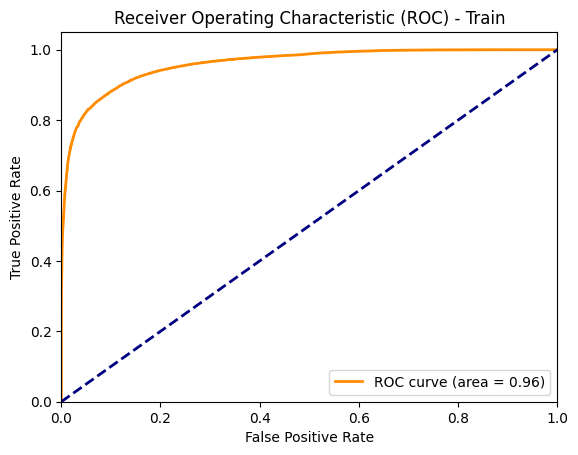

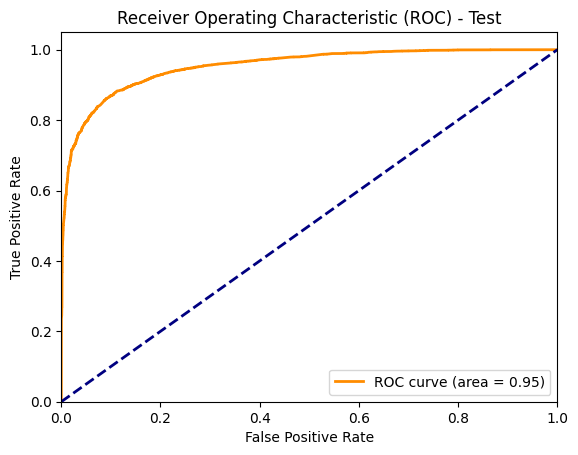

Evaluation using accuracy:
Accuracy train: 0.8898
Accuracy validation: 0.8789
Accuracy test: 0.8847

Evaluation using ROC AUC:
ROC AUC train: 0.9600
ROC AUC validation: 0.9511
ROC AUC test: 0.9526

Reporte de clasificacion del conjunto test:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      4594
           1       0.90      0.88      0.89      5406

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('titulo',
                                                  TfidfVectorizer(max_features=10000),
                                                  'title'),
                                                 ('garantia',
                                                  TfidfVectorizer(max_features=10000),
                                                  'warranty'),
                                                 ('cat', OneHotEncoder(),
                                                  ['sold_quantity_category',
                                                   'listing_type_id',
                                                   'buying_mode',
                                                   'shipping_mode',
                                                   'available_quantity_category',
                                                   'shipping_local_pick_up',
                                                   'shipping_free_ship...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [14]:

# Lista de variables de interes de acuerdo al EDA
features_list = ['title', 'price', 'sold_quantity_category', 'listing_type_id', 
                 'days_active', 'buying_mode', 'available_quantity_category', 
                 'shipping_local_pick_up', 'shipping_free_shipping', 'shipping_mode',
                 'has_variations', 'warranty']

# Seleccionar variables de interés
X_train = X_train_df[features_list]
X_test = X_test_df[features_list]


# Definir el modelo XGBoost
model = XGBClassifier()

# Preprocesamiento de datos
# TfidfVectorizer para textos
# OneHotEncoder para las categoricas
# StandardScaler para las variables continuas
preprocessor = ColumnTransformer(
    transformers=[
        ('titulo', TfidfVectorizer(max_features=10000), 'title'),
        ('garantia', TfidfVectorizer(max_features=10000), 'warranty'),
        ('cat', OneHotEncoder(), ['sold_quantity_category', 'listing_type_id', 'buying_mode', 'shipping_mode',
                                  'available_quantity_category', 'shipping_local_pick_up', 'shipping_free_shipping',
                                  'has_variations']),
        ('num', StandardScaler(), ['price', 'days_active'])
    ])

# Crear el pipeline con el preprocesador y el modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Definir la rejilla de parámetros para la búsqueda
param_grid = {
    # 'classifier__n_estimators': [50, 100, 150],           # Number of boosting rounds
    'classifier__learning_rate': [0.01, 0.1, 0.2],        # Step size shrinkage used in update to prevent overfitting
    # 'classifier__max_depth': [3, 5, 7],                   # Maximum depth of a tree
    # 'classifier__subsample': [0.6, 0.8, 1.0],             # Subsample ratio of the training instances
    # 'classifier__colsample_bytree': [0.6, 0.8, 1.0],      # Subsample ratio of columns when constructing each tree
    # 'classifier__gamma': [0, 0.1, 0.2],                   # Minimum loss reduction required to make a further partition on a leaf node of the tree
    # 'classifier__reg_alpha': [0, 0.5, 1],                 # L1 regularization term on weights
    # 'classifier__reg_lambda': [0, 0.5, 1]                 # L2 regularization term on weights
}

# # Crear el GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')

# # Entrenar el modelo con búsqueda de hiperparámetros
# grid_search.fit(X_train, y_train)

# # Imprimir los mejores parámetros y el mejor puntaje
# print("Best parameters found: ", grid_search.best_params_)
# print("Best cross-validation score (ROC AUC): ", grid_search.best_score_)
# print("")

# pipeline = show_evaluation(X_train, y_train, X_test, y_test, grid_search.best_estimator_, show_test=True)
pipeline = show_evaluation(X_train, y_train, X_test, y_test, pipeline, show_test=True)

pipeline

In [15]:
from sklearn.svm import SVC

# Lista de variables de interes de acuerdo al EDA
features_list = ['title', 'price', 'sold_quantity_category', 'listing_type_id', 
                 'days_active', 'buying_mode', 'available_quantity_category', 
                 'shipping_local_pick_up', 'shipping_free_shipping', 'shipping_mode',
                 'has_variations', 'warranty']

# Seleccionar variables de interés
X_train = X_train_df[features_list]
X_test = X_test_df[features_list]

# Definir el modelo XGBoost
model = SVC(random_state = 42)

# Preprocesamiento de datos
# TfidfVectorizer para textos
# OneHotEncoder para las categoricas
# StandardScaler para las variables continuas
preprocessor = ColumnTransformer(
    transformers=[
        ('titulo', TfidfVectorizer(max_features=10000), 'title'),
        ('garantia', TfidfVectorizer(max_features=10000), 'warranty'),
        ('cat', OneHotEncoder(), ['sold_quantity_category', 'listing_type_id', 'buying_mode', 'shipping_mode',
                                  'available_quantity_category', 'shipping_local_pick_up', 'shipping_free_shipping',
                                  'has_variations']),
        ('num', StandardScaler(), ['price', 'days_active'])
    ])

# Crear el pipeline con el preprocesador y el modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Definir la rejilla de parámetros para la búsqueda
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__degree': [2, 3, 4],  # Solo relevante para el kernel 'poly'
    'classifier__coef0': [0.0, 0.1, 0.5, 1.0]  # Relevante para 'poly' y 'sigmoid'
}

# # Crear el GridSearchCV
# grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')

# # Entrenar el modelo con búsqueda de hiperparámetros
# grid_search.fit(X_train, y_train)

# # Imprimir los mejores parámetros y el mejor puntaje
# print("Best parameters found: ", grid_search.best_params_)
# print("Best cross-validation score (ROC AUC): ", grid_search.best_score_)
# print("")

# pipeline = show_evaluation(X_train, y_train, X_test, y_test, grid_search.best_estimator_, show_test=True)
pipeline = show_evaluation(X_train, y_train, X_test, y_test, pipeline, show_test=True)

pipeline

#### 3.3. Neural Networks

Puede ayudar dada la alta dimensionalidad del problema.

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim

# Lista de variables de interes de acuerdo al EDA
features_list = ['title', 'price', 'sold_quantity_category', 'listing_type_id', 
                 'days_active', 'buying_mode', 'available_quantity_category', 
                 'shipping_local_pick_up', 'shipping_free_shipping', 'shipping_mode',
                 'has_variations', 'warranty']

# Seleccionar variables de interés
X_train = X_train_df[features_list]
X_test = X_test_df[features_list]

# Definir el modelo de red neuronal
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x
    
# Entrenamiento del modelo usando PyTorch
def train_model(X, y):
    input_size = X.shape[1]
    hidden_size = 64
    model = NeuralNet(input_size, hidden_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(100):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

    return model

# Evaluar el modelo utilizando validación cruzada y ROC AUC
def evaluate_model(model, X, y):
    y_pred = model(X).detach().numpy().flatten()
    return roc_auc_score(y, y_pred)

# Preprocesamiento de datos
# TfidfVectorizer para textos
# OneHotEncoder para las categoricas
# StandardScaler para las variables continuas
preprocessor = ColumnTransformer(
    transformers=[
        ('titulo', TfidfVectorizer(max_features=10000), 'title'),
        ('garantia', TfidfVectorizer(max_features=10000), 'warranty'),
        ('cat', OneHotEncoder(), ['sold_quantity_category', 'listing_type_id', 'buying_mode', 'shipping_mode',
                                  'available_quantity_category', 'shipping_local_pick_up', 'shipping_free_shipping',
                                  'has_variations']),
        ('num', StandardScaler(), ['price', 'days_active'])
    ])

# Crear el pipeline con el preprocesador y el modelo
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Aplicar el pipeline a los datos de entrenamiento y prueba
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

# Entrenar y evaluar el modelo con validación cruzada
model = train_model(torch.tensor(X_train_processed).float(), torch.tensor(y_train.values).float())
cv_scores = cross_val_score(model, torch.tensor(X_train_processed).float(), torch.tensor(y_train.values).float(), cv=5, scoring='roc_auc')


# # Definir la rejilla de parámetros para la búsqueda
# param_grid = {
#     'classifier__n_estimators': [50, 100, 150],    # Number of trees in the forest
#     'classifier__max_depth': [None, 10, 20],       # Maximum depth of the tree
#     'classifier__min_samples_split': [2, 5, 10],   # Minimum number of samples required to split an internal node
#     'classifier__min_samples_leaf': [1, 2, 4],     # Minimum number of samples required to be at a leaf node
# }

# # # Crear el GridSearchCV
# # grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')

# # # Entrenar el modelo con búsqueda de hiperparámetros
# # grid_search.fit(X_train, y_train)

# # # Imprimir los mejores parámetros y el mejor puntaje
# # print("Best parameters found: ", grid_search.best_params_)
# # print("Best cross-validation score (ROC AUC): ", grid_search.best_score_)
# # print("")

# # pipeline = show_evaluation(X_train, y_train, X_test, y_test, grid_search.best_estimator_, show_test=True)
# pipeline = show_evaluation(X_train, y_train, X_test, y_test, pipeline, show_test=True)

pipeline

KeyboardInterrupt: 